This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# xarray CfRadial1 backend

In this example, we read and write CfRadial1 data files using the xarray `cfradial1` backend.

In [1]:
import wradlib as wrl
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as pl
import numpy as np
import xarray as xr
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()

## Load CfRadial1 Volume Data

In [2]:
fpath = 'netcdf/cfrad.20080604_002217_000_SPOL_v36_SUR.nc'
f = wrl.util.get_wradlib_data_file(fpath)
vol = wrl.io.open_cfradial1_dataset(f)

### Fix several issues of CfRadial1 azimuth's

In [3]:
for i, swp in enumerate(vol):
    num_rays = int(360 // swp.azimuth.diff("azimuth").median())
    start_rays = swp.dims["azimuth"] - num_rays
    vol[i] = swp.isel(azimuth=slice(start_rays, start_rays + num_rays )).sortby("azimuth")

### Inspect RadarVolume

In [4]:
display(vol)

<wradlib.RadarVolume>
Dimension(s): (sweep: 9)
Elevation(s): (0.5, 1.1, 1.8, 2.6, 3.6, 4.7, 6.5, 9.1, 12.8)

### Inspect root group

The `sweep` dimension contains the number of scans in this radar volume. Further the dataset consists of variables (location coordinates, time_coverage) and attributes (Conventions, metadata).

In [5]:
vol.root

<xarray.Dataset>
Dimensions:              (sweep: 9)
Coordinates:
    longitude            float64 120.4
    altitude             float64 45.0
    sweep_mode           <U20 'azimuth_surveillance'
    time                 datetime64[ns] 2008-06-04T00:15:03
    latitude             float64 22.53
Dimensions without coordinates: sweep
Data variables:
    volume_number        int64 0
    platform_type        <U5 'fixed'
    instrument_type      <U5 'radar'
    primary_axis         <U6 'axis_z'
    time_coverage_start  <U20 '2008-06-04T00:15:03Z'
    time_coverage_end    <U20 '2008-06-04T00:22:17Z'
    sweep_group_name     (sweep) <U7 'sweep_0' 'sweep_1' ... 'sweep_7' 'sweep_8'
    sweep_fixed_angle    (sweep) float64 0.5 1.1 1.8 2.6 3.6 4.7 6.5 9.1 12.8
Attributes:
    version:          None
    title:            None
    institution:      None
    references:       None
    source:           None
    history:          None
    comment:          im/exported using wradlib
    instrument_name:  None
    fixed_angle:      0.5

### Inspect sweep group(s)

The sweep-groups can be accessed via their respective keys. The dimensions consist of `range` and `time` with added coordinates `azimuth`, `elevation`, `range` and `time`. There will be variables like radar moments (DBZH etc.) and sweep-dependend metadata (like `fixed_angle`, `sweep_mode` etc.).

In [6]:
display(vol[0])

<xarray.Dataset>
Dimensions:                           (r_calib: 1, azimuth: 480, range: 996)
Coordinates:
    latitude                          float64 ...
    longitude                         float64 ...
    altitude                          float64 ...
    sweep_mode                        <U20 'azimuth_surveillance'
    rtime                             (azimuth) datetime64[ns] 2008-06-04T00:...
  * range                             (range) float32 150.0 300.0 ... 1.494e+05
  * azimuth                           (azimuth) float32 0.0 0.75 ... 358.5 359.2
    elevation                         (azimuth) float32 ...
    time                              datetime64[ns] 2008-06-04T00:15:03
Dimensions without coordinates: r_calib
Data variables: (12/92)
    volume_number                     int32 ...
    platform_type                     |S32 ...
    primary_axis                      |S32 ...
    status_xml                        |S1 ...
    instrument_type                   |S32 ...
    radar_antenna_gain_h              float32 ...
    ...                                ...
    r_calib_index                     (azimuth) int8 ...
    measured_transmit_power_h         (azimuth) float32 ...
    measured_transmit_power_v         (azimuth) float32 ...
    scan_rate                         (azimuth) float32 ...
    DBZ                               (azimuth, range) float32 ...
    VR                                (azimuth, range) float32 ...
Attributes:
    fixed_angle:  0.5

### Goereferencing

In [7]:
swp = vol[0].copy().pipe(wrl.georef.georeference_dataset)

### Plotting

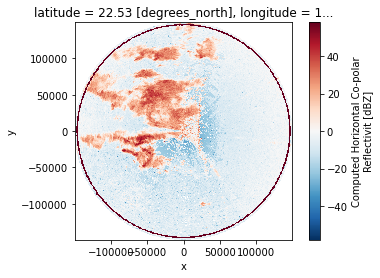

In [8]:
swp.DBZ.plot.pcolormesh(x='x', y='y')
pl.gca().set_aspect('equal')

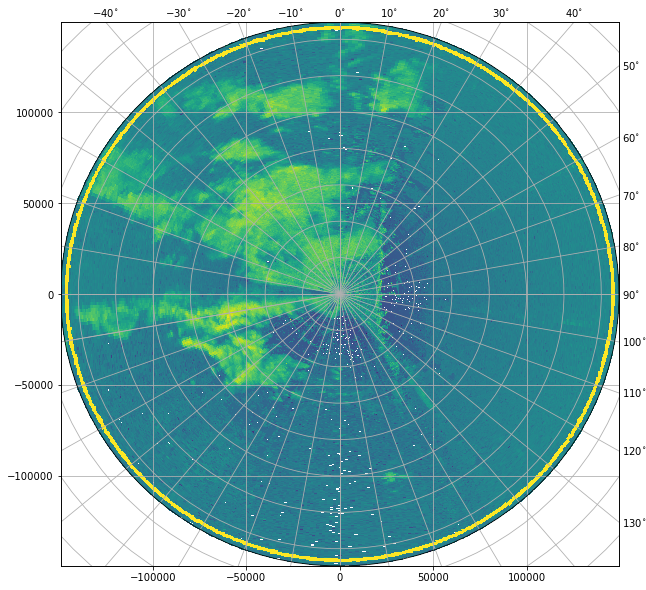

In [9]:
fig = pl.figure(figsize=(10,10))
swp.DBZ.wradlib.plot_ppi(proj='cg', fig=fig)

In [10]:
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

map_trans = ccrs.AzimuthalEquidistant(central_latitude=swp.latitude.values, 
                                      central_longitude=swp.longitude.values)

< GeoAxes: +proj=aeqd +ellps=WGS84 +lon_0=120.43350219726562 +lat_0=22.52669906616211 +x_0=0.0 +y_0=0.0 +no_defs +type=crs >


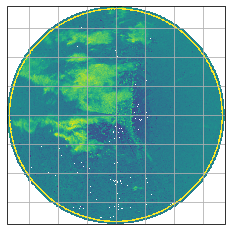

In [11]:
map_proj = ccrs.AzimuthalEquidistant(central_latitude=swp.latitude.values, 
                                      central_longitude=swp.longitude.values)
pm = swp.DBZ.wradlib.plot_ppi(proj=map_proj)
ax = pl.gca()
ax.gridlines(crs=map_proj)
print(ax)

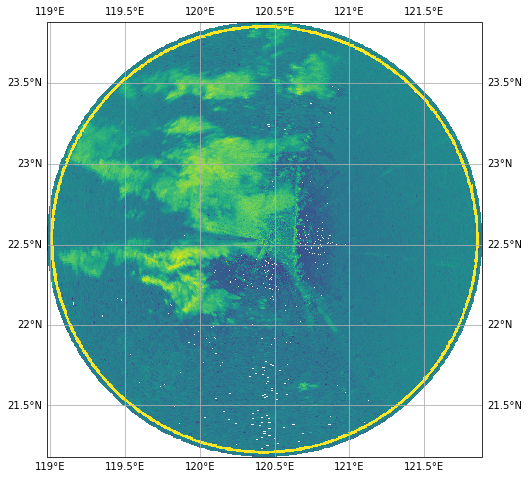

In [12]:
map_proj = ccrs.Mercator(central_longitude=swp.longitude.values)
fig = pl.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection=map_proj)
pm = swp.DBZ.wradlib.plot_ppi(ax=ax)
ax.gridlines(draw_labels=True)

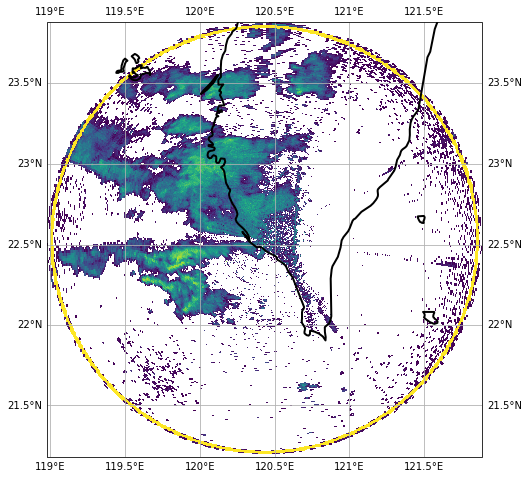

In [13]:
import cartopy.feature as cfeature
def plot_borders(ax):
    borders = cfeature.NaturalEarthFeature(category='physical',
                                           name='coastline',
                                           scale='10m',
                                           facecolor='none')
    ax.add_feature(borders, edgecolor='black', lw=2, zorder=4)

map_proj = ccrs.Mercator(central_longitude=swp.longitude.values)
fig = pl.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection=map_proj)

DBZ = swp.DBZ
pm = DBZ.where(DBZ > 0).wradlib.plot_ppi(ax=ax)
plot_borders(ax)
ax.gridlines(draw_labels=True)

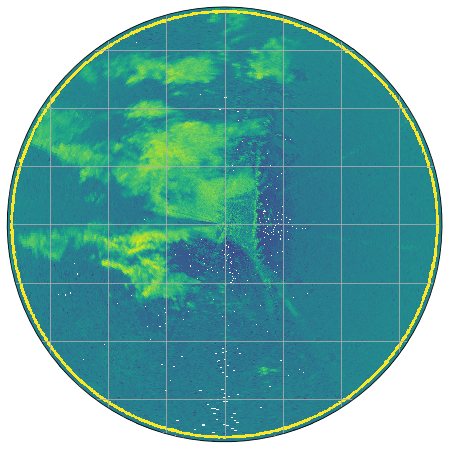

In [14]:
import matplotlib.path as mpath
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

map_proj = ccrs.AzimuthalEquidistant(central_latitude=swp.latitude.values, 
                                     central_longitude=swp.longitude.values,
                                    )
fig = pl.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection=map_proj)
ax.set_boundary(circle, transform=ax.transAxes)

pm = swp.DBZ.wradlib.plot_ppi(proj=map_proj, ax=ax)
ax = pl.gca()
ax.gridlines(crs=map_proj)

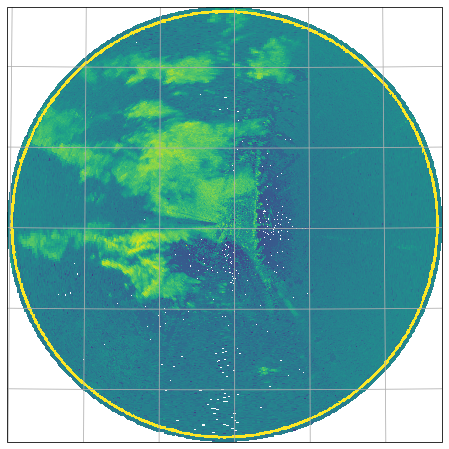

In [15]:
fig = pl.figure(figsize=(10, 8))
proj=ccrs.AzimuthalEquidistant(central_latitude=swp.latitude.values, 
                               central_longitude=swp.longitude.values)
ax = fig.add_subplot(111, projection=proj)
pm = swp.DBZ.wradlib.plot_ppi(ax=ax)
ax.gridlines()

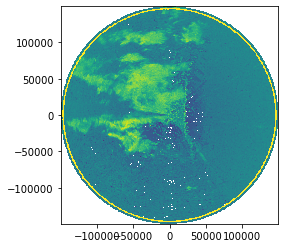

In [16]:
swp.DBZ.wradlib.plot_ppi()

### Inspect radar moments

The DataArrays can be accessed by key or by attribute. Each DataArray has dimensions and coordinates of it's parent dataset. There are attributes connected which are defined by Cf/Radial standard.

In [17]:
display(swp.DBZ)

<xarray.DataArray 'DBZ' (azimuth: 480, range: 996)>
array([[ 20.699957,  39.96934 ,  29.650644, ...,  -2.799595,  -3.549335,
         -1.650112],
       [ 13.829709,  35.710747,   8.869345, ..., -18.780428,  -3.080303,
         -4.519378],
       [ -9.129745,  14.810412,   4.539685, ...,   0.179822,  -0.550375,
         -3.519132],
       ...,
       [  5.889927,  26.049406,  32.379555, ...,  -2.550866,  -1.060269,
         -1.900617],
       [  0.959765,  23.579884,   9.29929 , ...,  -8.680257,  -5.039932,
         -2.410512],
       [ 20.079912,  39.15031 ,  13.190121, ...,  -4.91912 ,  -3.160252,
         -1.319658]], dtype=float32)
Coordinates: (12/15)
    latitude    float64 22.53
    longitude   float64 120.4
    altitude    float64 45.0
    sweep_mode  <U20 'azimuth_surveillance'
    rtime       (azimuth) datetime64[ns] 2008-06-04T00:15:34 ... 2008-06-04T0...
  * range       (range) float32 150.0 300.0 450.0 ... 1.492e+05 1.494e+05
    ...          ...
    x           (azimuth, range) float32 -6.556e-06 -1.311e-05 ... -1.955e+03
    y           (azimuth, range) float32 150.0 300.0 ... 1.492e+05 1.493e+05
    z           (azimuth, range) float32 46.0 47.0 48.0 ... 2.714e+03 2.718e+03
    gr          (azimuth, range) float32 150.0 300.0 ... 1.492e+05 1.494e+05
    rays        (azimuth, range) float32 0.0 0.0 0.0 0.0 ... 359.2 359.2 359.2
    bins        (azimuth, range) float32 150.0 300.0 ... 1.492e+05 1.494e+05
Attributes:
    long_name:             Computed Horizontal Co-polar Reflectivit
    standard_name:         equivalent_reflectivity_factor
    units:                 dBZ
    threshold_field_name:  
    threshold_value:       -9999.0
    sampling_ratio:        1.0
    grid_mapping:          grid_mapping

### Create simple plot

Using xarray features a simple plot can be created like this. Note the `sortby('time')` method, which sorts the radials by time.

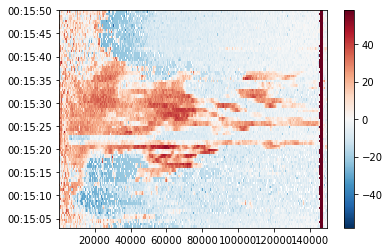

In [18]:
swp.DBZ.sortby('rtime').plot(x="range", y="rtime", add_labels=False)

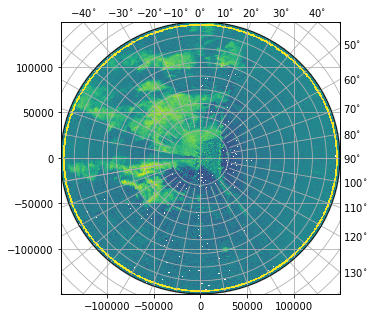

In [19]:
fig = pl.figure(figsize=(5,5))
pm = swp.DBZ.wradlib.plot_ppi(proj={'latmin': 33e3}, fig=fig)

### Mask some values

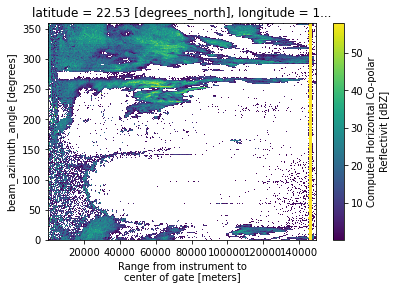

In [20]:
swp['DBZ'] = swp['DBZ'].where(swp['DBZ'] >= 0)
swp['DBZ'].plot()

### Export to ODIM and CfRadial2

In [21]:
vol.to_odim('cfradial1_as_odim.h5')
vol.to_cfradial2('cfradial1_as_cfradial2.nc')

### Import again

In [22]:
vola = wrl.io.open_odim_dataset('cfradial1_as_odim.h5', decode_coords=True, 
                                backend_kwargs=dict(keep_azimuth=True,
                                                   keep_elevation=False))

In [23]:
vola.root

<xarray.Dataset>
Dimensions:              (sweep: 9)
Coordinates:
    time                 datetime64[ns] 2008-06-04T00:15:03
    sweep_mode           <U20 'azimuth_surveillance'
    longitude            float64 120.4
    altitude             float64 45.0
    latitude             float64 22.53
Dimensions without coordinates: sweep
Data variables:
    volume_number        int64 0
    platform_type        <U5 'fixed'
    instrument_type      <U5 'radar'
    primary_axis         <U6 'axis_z'
    time_coverage_start  <U20 '2008-06-04T00:15:03Z'
    time_coverage_end    <U20 '2008-06-04T00:22:17Z'
    sweep_group_name     (sweep) <U7 'sweep_0' 'sweep_1' ... 'sweep_7' 'sweep_8'
    sweep_fixed_angle    (sweep) float64 0.5 1.1 1.8 2.6 3.6 4.7 6.5 9.1 12.8
Attributes:
    version:          None
    title:            None
    institution:      None
    references:       None
    source:           None
    history:          None
    comment:          im/exported using wradlib
    instrument_name:  None
    fixed_angle:      0.5

In [24]:
volb = wrl.io.open_cfradial2_dataset('cfradial1_as_cfradial2.nc')

### Check equality

Some variables need to be dropped, since they are not exported to the other standards.

In [25]:
drop = set(vol[0]) ^ set(vola[0]) | set({"elevation", "rtime"})
xr.testing.assert_allclose(vol.root, vola.root)
xr.testing.assert_allclose(vol[0].drop_vars(drop), vola[0].drop_vars(drop, errors="ignore"))
xr.testing.assert_allclose(vol.root, volb.root)
xr.testing.assert_equal(vol[0], volb[0])
xr.testing.assert_allclose(vola.root, volb.root)
xr.testing.assert_allclose(vola[0].drop_vars(drop, errors="ignore"), volb[0].drop_vars(drop, errors="ignore"))

## More CfRadial1 loading mechanisms

### Use `xr.open_dataset` to retrieve explicit group


In [26]:
swp = xr.open_dataset(f, engine="cfradial1", group="sweep_9")
display(swp)

<xarray.Dataset>
Dimensions:                           (r_calib: 1, azimuth: 483, range: 996)
Coordinates:
    latitude                          float64 ...
    longitude                         float64 ...
    altitude                          float64 ...
    sweep_mode                        <U20 ...
    rtime                             (azimuth) datetime64[ns] ...
  * range                             (range) float32 150.0 300.0 ... 1.494e+05
  * azimuth                           (azimuth) float32 198.8 212.2 ... 213.0
    elevation                         (azimuth) float32 ...
    time                              datetime64[ns] ...
Dimensions without coordinates: r_calib
Data variables: (12/92)
    volume_number                     int32 ...
    platform_type                     |S32 ...
    primary_axis                      |S32 ...
    status_xml                        |S1 ...
    instrument_type                   |S32 ...
    radar_antenna_gain_h              float32 ...
    ...                                ...
    r_calib_index                     (azimuth) int8 ...
    measured_transmit_power_h         (azimuth) float32 ...
    measured_transmit_power_v         (azimuth) float32 ...
    scan_rate                         (azimuth) float32 ...
    DBZ                               (azimuth, range) float32 ...
    VR                                (azimuth, range) float32 ...
Attributes:
    fixed_angle:  12.8